# IST 652 Final Project - A Pantheon Exploration

# Introduction

Recorded human history has only been around for 5000 years. By understanding the makeup of Pantheon, all persons today both young and old are enriched with the knowledge of global, scientific and cultural development of humanity. The meaning of the word *Pantheon* describes a group of particularly respected, famous, or important people. Over the course of human history there have been thousands of such individuals that have made an impact on society. Due to the information age that began in the latter part of the 20th century, people all over the world now have access to the same biographies of these individuals through Wikipedia in multiple languages. What was once information of limited accessibility and supply, shelved in remote libraries, is now conveniently made available through this medium.

Credit goes to the Macro Connections group at the Massachusetts Institute of Technology Media Lab and their [Pantheon Project](https://www.kaggle.com/mit/pantheon-project). Not only was a Pantheon index made available to the general public, but a popularity index was created as well. One "barrier to entry" to this content is the number of languages available for each article. This is a key measure in determining the popularity of individuals in the Pantheon. "The simpler of the two measures, which we denote as L, is the number of different Wikipedia language editions that have an article about a historical character. The more sophisticated measure, which we name the Historical Popularity Index (HPI) corrects L by adding information on the age of the historical character, the concentration of page views among different languages, the coefficient of variation in page views, and the number of page views in languages other than English." [https://www.kaggle.com/mit/pantheon-project](https://www.kaggle.com/mit/pantheon-project)

The significance of historical figures may be debatable, but this report seeks to apply an objective measure of popularity to better understand how biographies of the Pantheon is being consumed in the current day and age. From Aristotle to Benjamin Franklin, Jesus Christ to Al Pacino, historical figures and their attributes will be measured with web analytics so that the reader may have insights into the following:

Research questions:

* Which historic characters are the most popular?
* When did they live and where are they from?
* What factors could have generated their popularity?
* Are there any observable trends in the categorical data provided?
* What clusters and groupings are in the data? How do groups compare in popularity?

# Analysis

Key analysis methods used in report:
* Data Cleaning
* Sorting and subsets of the data.
* Line and bar plots.
* Multiple regression

In [178]:
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn

## About the Data

In [179]:
dataFileName = "data/database.csv"
isExist = os.path.isfile(dataFileName)
if isExist == True:
    dfDirtyData = pd.read_csv(dataFileName, sep=",", header=0)
else:
    print("File not found:", os.getcwd())


A variable called dataFileName is create to store the data file name. Then the dataFileName is checked to make it exists in the current working directory. The boolean value then stored in isExist variable. If the value of the isExist is true then the file is loaded into a Pandas dataframe otherwise a message is printed to remind that the file does exists or miss-spelled.

In [180]:
dfDirtyData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11341 entries, 0 to 11340
Data columns (total 17 columns):
article_id                     11341 non-null int64
full_name                      11341 non-null object
sex                            11341 non-null object
birth_year                     11341 non-null object
city                           11341 non-null object
state                          2172 non-null object
country                        11308 non-null object
continent                      11311 non-null object
latitude                       10294 non-null float64
longitude                      10294 non-null float64
occupation                     11341 non-null object
industry                       11341 non-null object
domain                         11341 non-null object
article_languages              11341 non-null int64
page_views                     11341 non-null int64
average_views                  11341 non-null int64
historical_popularity_index    11341 non-null 

The .info() function is used to display the information about the dataframe. This function provides the dataframe information such as column names, total count of rows for each column, and data types. 

In [181]:
columnToDisplayDirtyData = ['full_name', 'sex', 'birth_year', 'country', 'occupation','historical_popularity_index']

There too many columns in the dataset that would not fit nicely on the report. A variable called columnToDisplayDirtyData is created to store customized number of columns to display. There are six columns included: full_name', 'sex', 'birth_year', 'country', 'occupation', and 'historical_popularity_index'

In [182]:
dfDirtyData.loc[1522]

article_id                             23671899
full_name                                Elisha
sex                                        Male
birth_year                              Unknown
city                                      Other
state                                       NaN
country                                 Unknown
continent                               Unknown
latitude                                    NaN
longitude                                   NaN
occupation                     Religious Figure
industry                               Religion
domain                             Institutions
article_languages                            41
page_views                              1338790
average_views                             32653
historical_popularity_index             25.5087
Name: 1522, dtype: object

The .loc() function is used to locate a row data based the row index to display on the report.


In [183]:
dfDirtyData.loc[:,columnToDisplayDirtyData].head(5)

,full_name,sex,birth_year,country,occupation,historical_popularity_index
0,Aristotle,Male,-384,Greece,Philosopher,31.9938
1,Plato,Male,-427,Greece,Philosopher,31.9888
2,Jesus Christ,Male,-4,Israel,Religious Figure,31.8981
3,Socrates,Male,-469,Greece,Philosopher,31.6521
4,Alexander the Great,Male,-356,Greece,Military Personnel,31.5840


The .head(5) function is used to display the first 5 rows in the dataset. The columns to display are based on the variable called columnToDisplayDirtyData.

In [184]:
dfDirtyData.loc[:,columnToDisplayDirtyData].tail(5)

,full_name,sex,birth_year,country,occupation,historical_popularity_index
11336,Sean St Ledger,Male,1984,United Kingdom,Soccer Player,11.1346
11337,Saina Nehwal,Female,1990,India,Athlete,10.6122
11338,Rūta Meilutytė,Female,1997,Lithuania,Swimmer,10.3821
11339,Vladimír Weiss,Male,1989,Slovakia,Soccer Player,10.2495
11340,Missy Franklin,Female,1995,United States,Swimmer,9.8794


The .tail(5) function is used to display the last 5 rows in the dataset. The columns to display are based on the variable called columnToDisplayDirtyData.

## Data Cleaning
#### There are data issues so there are a few functions were create to help automate the cleaning process.

In [185]:
def fillNaN(df, dataType, defaultValue):
    for column in df.columns:
        if(df[column].dtype == dataType):
            df[column].fillna(value = defaultValue, inplace=True)

fillNaN() function takes three input paramters: data frame, data Type, and default value. This function is designed to replace the NaN value with the default value provided by the caller based on a matching data type. Below are examples on how the function can be called:
* fillNaN(dfCleanData,'object', 'Unknown')
* fillNaN(dfCleanData,'float64', 12345.888)

In [186]:
def removeCharFromNumber(inputValue):
    a = ''
    inputValue = str(inputValue)
    for char in inputValue:
        if char.isdigit() == True:
            a = a + char
    return a

removeCharFromNumber() function takes one inpurt parameter: string or text. This function iterates through, finds, and concatenates numbers together. This function is taking care of the hardcoded operation like, "dfCleanData['birth_year'].replace([['1237?']], 1237).replace([['530s']], 530)".

Below is the example on how the function can be called:
* removeCharFromNumber('127?')



In [187]:
def convertToNumber(df, columns):
    for col in columns:
        for idx, value in enumerate(df[col]):
            try:
                int(value)
            except:
                newValue = ''
                newValue = removeCharFromNumber(value)
                if newValue != '':
                    df.loc[idx, col] = newValue
                else:
                    df.loc[idx, col] = 0

convertToNumber() function takes two input parameters: a dataframe and a list of column names. This function is designed to convert the values for each column from possible alpha-numeric to numeric and default the value to zero if nothing is there.

Example:
* columnList = [['birth_year', 'latitude', 'longitude']]
* convertToNumber(dataframe, columnList)

In [188]:
dfCleanData = dfDirtyData.copy()

The .copy() function is used to make a copy of the original dataframe into a new one. This way when the modification is made to the new dataframe, data in the original dataframe will not be touched.

In [189]:
dfCleanData.rename(columns={'historical_popularity_index': 'popularity'}, inplace=True)

'historical_popularity_index' column is being rename as 'popularity' so it fits much nicely for displaying purposes.

In [190]:
fillNaN(dfCleanData, 'object', 'Unknown')

fillNaN() function is called by passing a dataframe (dfCleanData), data type ('object'), and default value ('Unknown). The funtion then go through the dataframe, looking for columns with 'object' data type then replace 'na' with 'Unknown'

In [191]:
columnToNumeric = ["article_languages", "birth_year", "latitude", "longitude", "page_views","average_views", "popularity"]
convertToNumber(dfCleanData, columnToNumeric)
dfCleanData[columnToNumeric] = dfCleanData[columnToNumeric].apply(pd.to_numeric)

columnToNumeric is a variable to hold a list of columns that will be converted into a numeric data type using pd.to_numeric() function. But before this, columnToNumeric() function is called so it will make sure that the values in those columns are all numeric.

In [192]:
# Showing inforamtion about the dataframe
dfCleanData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11341 entries, 0 to 11340
Data columns (total 17 columns):
article_id           11341 non-null int64
full_name            11341 non-null object
sex                  11341 non-null object
birth_year           11341 non-null int64
city                 11341 non-null object
state                11341 non-null object
country              11341 non-null object
continent            11341 non-null object
latitude             11341 non-null float64
longitude            11341 non-null float64
occupation           11341 non-null object
industry             11341 non-null object
domain               11341 non-null object
article_languages    11341 non-null int64
page_views           11341 non-null int64
average_views        11341 non-null int64
popularity           11341 non-null float64
dtypes: float64(3), int64(5), object(9)
memory usage: 1.5+ MB


The .info() function is used to display the information about the clean dataframe. This function provides the dataframe information such as column names, total count of rows for each column, and data types. 

In [193]:
print('Dirty Data:', dfDirtyData[dfDirtyData['birth_year'] == '1237?'].loc[:,'birth_year'])
print()
print('Clean Data:', dfCleanData[dfCleanData['birth_year'] == 1237].loc[:,'birth_year'])


Dirty Data: 3009    1237?
Name: birth_year, dtype: object

Clean Data: 3009    1237
Name: birth_year, dtype: int64


In [194]:
print('Dirty Data:', dfDirtyData[dfDirtyData['article_id'] == 23671899].loc[:,'birth_year'])
print()
print('Clean Data:', dfCleanData[dfCleanData['article_id'] == 23671899].loc[:,'birth_year'])

Dirty Data: 1522    Unknown
Name: birth_year, dtype: object

Clean Data: 1522    0
Name: birth_year, dtype: int64


Both dirty data and clean data are displaying to make sure the convertToNumber() function is massaging the data to the numeric data type properly as it is designed to do.

In [195]:
print('Dirty Data:', dfDirtyData[dfDirtyData['article_id'] == 23671899].loc[:,'state'])
print()
print('Clean Data:', dfCleanData[dfCleanData['article_id'] == 23671899].loc[:,'state'])

Dirty Data: 1522    NaN
Name: state, dtype: object

Clean Data: 1522    Unknown
Name: state, dtype: object


Both dirty data and clean data are displaying to make sure the fillNaN() function is replacing 'NaN' with the provided default value properly as it is designed to do.

In [196]:
# Creating a varibale to hold fields for displaying purpose since not all will fit
columnToDisplayCleanData = ['full_name', 'sex', 'birth_year', 'country', 'industry','domain','occupation','popularity']

In [197]:
# Showing the first 5 rows of the data in the dataset
dfCleanData.loc[:,columnToDisplayCleanData].head(5)

,full_name,sex,birth_year,country,industry,domain,occupation,popularity
0,Aristotle,Male,-384,Greece,Philosophy,Humanities,Philosopher,31.9938
1,Plato,Male,-427,Greece,Philosophy,Humanities,Philosopher,31.9888
2,Jesus Christ,Male,-4,Israel,Religion,Institutions,Religious Figure,31.8981
3,Socrates,Male,-469,Greece,Philosophy,Humanities,Philosopher,31.6521
4,Alexander the Great,Male,-356,Greece,Military,Institutions,Military Personnel,31.5840


The .head(5) function is used to display the first 5 rows in the dataset. The columns to display are based on the values in a variable called columnToDisplayCleanData.

In [198]:
dfCleanData.loc[:,columnToDisplayCleanData].tail(5)

,full_name,sex,birth_year,country,industry,domain,occupation,popularity
11336,Sean St Ledger,Male,1984,United Kingdom,Team Sports,Sports,Soccer Player,11.1346
11337,Saina Nehwal,Female,1990,India,Individual Sports,Sports,Athlete,10.6122
11338,Rūta Meilutytė,Female,1997,Lithuania,Individual Sports,Sports,Swimmer,10.3821
11339,Vladimír Weiss,Male,1989,Slovakia,Team Sports,Sports,Soccer Player,10.2495
11340,Missy Franklin,Female,1995,United States,Individual Sports,Sports,Swimmer,9.8794


The .tail(5) function is used to display the first 5 rows in the dataset. The columns to display are based on the values in a variable called columnToDisplayCleanData.

## Exploration

In [213]:
dfTopMostPopular = pd.DataFrame(dfCleanData.sort_values(by = ['popularity'], ascending = False).loc[:,columnToDisplayCleanData].head(10))
dfTopMostPopular

,full_name,sex,birth_year,country,industry,domain,occupation,popularity
0,Aristotle,Male,-384,Greece,Philosophy,Humanities,Philosopher,31.9938
1,Plato,Male,-427,Greece,Philosophy,Humanities,Philosopher,31.9888
2,Jesus Christ,Male,-4,Israel,Religion,Institutions,Religious Figure,31.8981
3,Socrates,Male,-469,Greece,Philosophy,Humanities,Philosopher,31.6521
4,Alexander the Great,Male,-356,Greece,Military,Institutions,Military Personnel,31.5840
5,Leonardo da Vinci,Male,1452,Italy,Invention,Science & Technology,Inventor,31.4644
6,Confucius,Male,-551,China,Philosophy,Humanities,Philosopher,31.3705
7,Julius Caesar,Male,-100,Italy,Government,Institutions,Politician,31.1161
8,Homer,Male,-800,Turkey,Language,Humanities,Writer,31.1087
9,Pythagoras,Male,-570,Greece,Philosophy,Humanities,Philosopher,31.0691


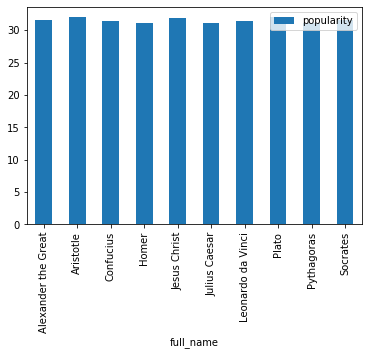

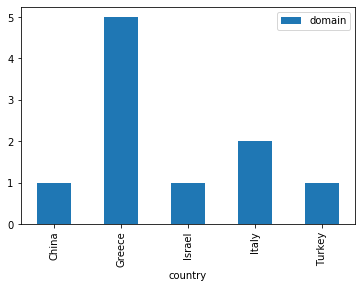

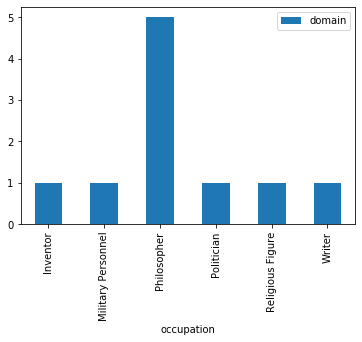

In [236]:
pd.DataFrame(dfTopMostPopular.groupby(['full_name'])['popularity'].sum()).plot.bar()
pd.DataFrame(dfTopMostPopular.groupby(['country'])['domain'].count()).plot.bar()
pd.DataFrame(dfTopMostPopular.groupby(['occupation'])['domain'].count()).plot.bar()

In [ ]:
pd.DataFrame(dfTopMostPopular.groupby(['country'])['domain'].count()).plot(kind='bar')

### Which historic characters are the most popular? When did they live and where are they from?
The table above are the top 10 of the historic characters are the most popular based on their popularity index. There are not many countries made the list.

In [238]:
dfTopLeastPopular = pd.DataFrame(dfCleanData.sort_values(by = ['popularity'], ascending = True).loc[:,columnToDisplayCleanData].head(10))
dfTopLeastPopular

,full_name,sex,birth_year,country,industry,domain,occupation,popularity
11340,Missy Franklin,Female,1995,United States,Individual Sports,Sports,Swimmer,9.8794
11339,Vladimír Weiss,Male,1989,Slovakia,Team Sports,Sports,Soccer Player,10.2495
11338,Rūta Meilutytė,Female,1997,Lithuania,Individual Sports,Sports,Swimmer,10.3821
11337,Saina Nehwal,Female,1990,India,Individual Sports,Sports,Athlete,10.6122
11336,Sean St Ledger,Male,1984,United Kingdom,Team Sports,Sports,Soccer Player,11.1346
11335,Jetro Willems,Male,1994,Netherlands,Team Sports,Sports,Soccer Player,11.3956
11334,Rebecca Soni,Female,1987,United States,Individual Sports,Sports,Swimmer,11.4050
11333,Sun Yang,Male,1991,China,Individual Sports,Sports,Swimmer,11.6234
11332,Shane Long,Male,1987,Ireland,Team Sports,Sports,Soccer Player,11.7174
11331,Marc Albrighton,Male,1989,United Kingdom,Team Sports,Sports,Soccer Player,11.7258


### Which historic characters are the least popular? When did they live and where are they from?
The table above are the top 10 of the historic characters are the least popular based on their popularity index. There are more countries made the list on the least popular crowd.

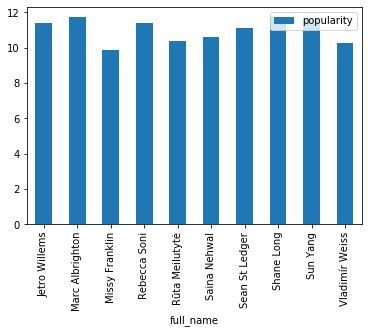

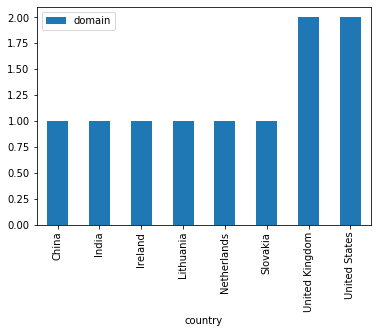

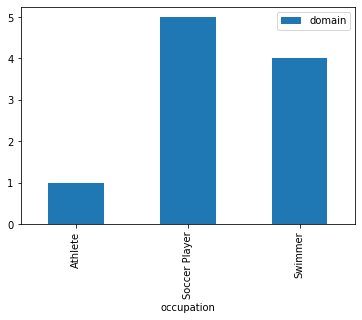

In [239]:
pd.DataFrame(dfTopLeastPopular.groupby(['full_name'])['popularity'].sum()).plot.bar()
pd.DataFrame(dfTopLeastPopular.groupby(['country'])['domain'].count()).plot.bar()
pd.DataFrame(dfTopLeastPopular.groupby(['occupation'])['domain'].count()).plot.bar()

In [201]:
dfTotalByContinentBySex = pd.DataFrame(dfCleanData.groupby(['sex'])['article_id'].count())
dfTotalByContinentBySex.rename(columns={'article_id': 'total_count'}, inplace=True)
dfTotalByContinentBySex

,total_count
sex,
Female,1495
Male,9846


The total number of male vs. female in comparison.

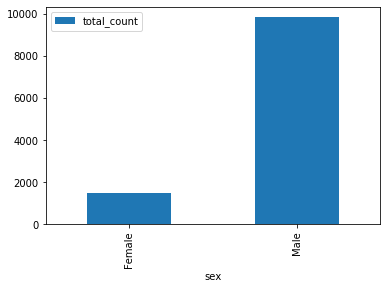

In [202]:
dfTotalByContinentBySex.plot(kind='bar')

In [203]:
dfTotalByContinentBySex = pd.DataFrame(dfCleanData.groupby(['industry','occupation','sex'])['article_id'].count())
dfTotalByContinentBySex.rename(columns={'article_id': 'total_count'}, inplace=True)
dfTotalByContinentBySex.sort_values(by = ['industry'], ascending =True).head(10)

total_count
industry         occupation         sex                
Activism         Social Activist    Female           38
                                    Male             76
Business         Businessperson     Female            4
                                    Male             75
                 Producer           Male             12
Companions       Companion          Female           94
                                    Male              7
Computer Science Computer Scientist Female            1
                                    Male             32
Dance            Dancer             Female            7

Generating a list of people by industry, occupation, and sex.

In [204]:
dfTotalByContinentBySex.sort_values(by = ['total_count'], ascending = False).head(10)

total_count
industry         occupation       sex                
Government       Politician       Male           2397
Team Sports      Soccer Player    Male           1059
Language         Writer           Male            844
Film And Theatre Actor            Male            692
                                  Female          501
Religion         Religious Figure Male            486
Music            Musician         Male            345
Philosophy       Philosopher      Male            275
Natural Sciences Physicist        Male            265
Music            Singer           Female          225

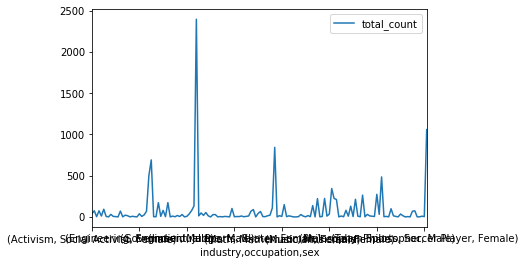

In [252]:
dfTotalByContinentBySex.plot.line()

Generating a list of people by industry, occupation, and sex but sorting in decending order of total count.

In [205]:
#'Activism' 'Business', 'Companions', 'Computer Science' 'Dance' 'Design' 'Engineering' 'Explorers' 'Film And Theatre' 'Fine Arts'
#'Government' 'History' 'Individual Sports' 'Invention' 'Language' 'Law' 'Math' 'Media Personality' 'Medicine'
#'Military' 'Music' 'Natural Sciences' 'Outlaws' 'Philosophy' 'Religion' 'Social Sciences' 'Team Sports'
industry = 'Computer Science'
dfByIndustry = dfCleanData[dfCleanData['industry'] == industry].loc[:,columnToDisplayCleanData].sort_values(by = ['birth_year'], ascending = False)
dfByIndustry.head(10)

,full_name,sex,birth_year,country,industry,domain,occupation,popularity
9075,Sergey Brin,Male,1973,Russia,Computer Science,Science & Technology,Computer Scientist,19.4307
8734,Larry Page,Male,1973,United States,Computer Science,Science & Technology,Computer Scientist,20.0560
6165,Linus Torvalds,Male,1969,Finland,Computer Science,Science & Technology,Computer Scientist,22.7527
9562,Rasmus Lerdorf,Male,1968,Greenland,Computer Science,Science & Technology,Computer Scientist,18.4731
7016,Kevin Mitnick,Male,1963,United States,Computer Science,Science & Technology,Computer Scientist,22.1970
9461,Randy Pausch,Male,1960,United States,Computer Science,Science & Technology,Computer Scientist,18.6506
9533,Stephen Wolfram,Male,1959,United Kingdom,Computer Science,Science & Technology,Computer Scientist,18.5298
7626,Eric S. Raymond,Male,1957,United States,Computer Science,Science & Technology,Computer Scientist,21.6362
9296,Alexey Pazhitnov,Male,1956,Russia,Computer Science,Science & Technology,Computer Scientist,19.0038
9036,Guido van Rossum,Male,1956,Netherlands,Computer Science,Science & Technology,Computer Scientist,19.4986


The list of people based on the industry the are in. The parameter value the industry can be changed to look for specific one.

In [206]:
dfTotalTop10ByCountry = pd.DataFrame(dfTopTenMostPopularPeople.groupby(['country'])['article_id'].count())
dfTotalTop10ByCountry.rename(columns={'article_id': 'total_count'}, inplace=True)
dfTotalTop10ByCountry.sort_values(by = ['total_count'], ascending = False).head(10)

,total_count
country,
United States,2169
United Kingdom,1147
France,867
Italy,809
Germany,748
Unknown,468
Russia,374
Spain,296
Turkey,204


Top ten highest numbers of people from each country.

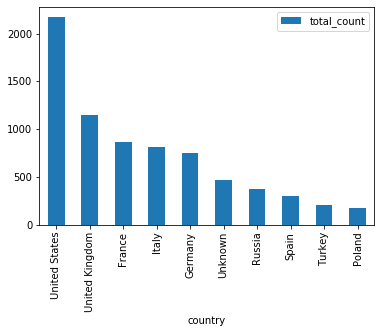

In [247]:
dfTotalTop10ByCountry.sort_values(by = ['total_count'], ascending = False).head(10).plot.bar()

In [207]:
dfTotalByContinent = pd.DataFrame(dfCleanData.groupby(['continent'])['article_id'].count())
dfTotalByContinent.rename(columns={'article_id': 'total_count'}, inplace=True)
dfTotalByContinent.sort_values(by = ['total_count'], ascending = False)

,total_count
continent,
Europe,6368
North America,2439
Asia,1188
Unknown,438
Africa,419
South America,366
Oceania,123


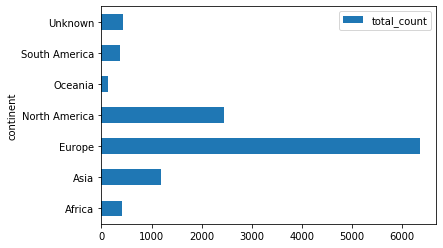

In [249]:
dfTotalByContinent.plot.barh()

The list of total count for each continent

## Modeling

# Results

# Conclusion